In [1]:
import numpy as np
import torch
import pickle
import sys
from tqdm import tqdm
from joblib import Parallel, delayed
from pyro.distributions.empirical import Empirical

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils
from sbi import analysis

# distances
from scipy.spatial.distance import directed_hausdorff
from torch.nn.functional import normalize

In [2]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
prior_min = [.5,1e-4,1e-4,1e-4,50,40,1e-4,35]
prior_max = [80.,15.,0.6,0.6,3000,90,0.15,100]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), 
                                    high=torch.as_tensor(prior_max))

## Simulator

In [4]:
from HH_Helpers import syn_current, calculate_summary_statistics

I, t_on, t_off, dt, t, A_soma = syn_current()

In [5]:
from HH_Helpers import HHsimulator

In [6]:
def run_HH_model(params):

    params = np.asarray(params)
    
    # input current, time step
    I, t_on, t_off, dt, t, A_soma = syn_current()

    t = np.arange(0, len(I), 1)*dt

    # initial voltage
    V0 = -70
    
    states = HHsimulator(V0, params.reshape(1, -1), dt, t, I)

    return dict(data=states.reshape(-1), time=t, dt=dt, I=I.reshape(-1))

In [7]:
params_base = [[50., 1.],[4., 1.5],[20., 15.]]
params_additional = [0.1,0.07,6e2,-60.,-.1,-70.0]
params = np.array([params_var + params_additional for params_var in params_base])

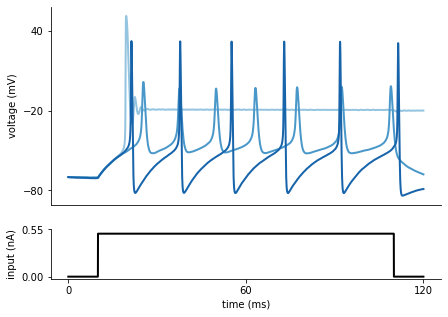

In [8]:
# three sets of (g_Na, g_K)
num_samples = len(params[:,0])
sim_samples = np.zeros((num_samples, len(I)))
for i in range(num_samples):
    sim_samples[i,:] = run_HH_model(params=params[i,:])['data']

# colors for traces
col_min = 2
num_colors = num_samples+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]

fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_samples):
    plt.plot(t,sim_samples[i,:],color=col1[i],lw=2)
plt.ylabel('voltage (mV)')
ax.set_xticks([])
ax.set_yticks([-80, -20, 40])

ax = plt.subplot(gs[1])
plt.plot(t,I*A_soma*1e3,'k', lw=2)
plt.xlabel('time (ms)')
plt.ylabel('input (nA)')

ax.set_xticks([0, max(t)/2, max(t)])
ax.set_yticks([0, 1.1*np.max(I*A_soma*1e3)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

In [9]:
def summ_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = run_HH_model(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))
    return summstats

In [10]:
def full_simulation_wrapper(params):
    """
    Returns summary statistics from conductance values in `params`.
    
    Summarizes the output of the HH simulator and converts it to `torch.Tensor`.
    """
    obs = torch.tensor(run_HH_model(params)['data'])
    return obs

## Distances

In [11]:
def hausdorff_dist(x,y, reverse = False):
    x_pairs = np.array([x['time'],x['data']]).T
    y_pairs = np.array([y['time'],y['data']]).T
    if reverse:
        return directed_hausdorff(y_pairs,x_pairs)
    return directed_hausdorff(x_pairs,y_pairs)
    # x_pairs = torch.vstack([x['time'],x['data']])


## Simulator

In [12]:
true_params = prior.sample()
observation_trace = run_HH_model(true_params)

grid_simulator, prior = prepare_for_sbi(full_simulation_wrapper,prior)
theta, data = simulate_for_sbi(grid_simulator, prior, num_simulations=100, num_workers=7)

data_np = data.detach().numpy()

time = observation_trace['time']

Running 100 simulations in 100 batches.:   0%|          | 0/100 [00:00<?, ?it/s]

In [13]:
def get_hausdorff_simulator(data):

    def hausdorff_simulator(params, input = None):
        if input is None:
            input = run_HH_model(params)
        distances = []
        for array in data:
            aug_data = {'time':time, 'data':array}
            distances.append(torch.tensor(hausdorff_dist(input,aug_data)[0]))
        return torch.tensor(distances)
    
    return hausdorff_simulator


In [14]:
hausdorff_simulator = get_hausdorff_simulator(data_np)

In [15]:
points_ref = hausdorff_simulator(true_params, observation_trace)
summs_ref = calculate_summary_statistics(observation_trace)

In [16]:
posterior=infer(hausdorff_simulator, prior, method='SNPE', 
                  num_simulations=1000, num_workers=7)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [93]:
list(zip(prior_min, prior_max))

[(0.5, 80.0),
 (0.0001, 15.0),
 (0.0001, 0.6),
 (0.0001, 0.6),
 (50, 3000),
 (40, 90),
 (0.0001, 0.15),
 (35, 100)]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

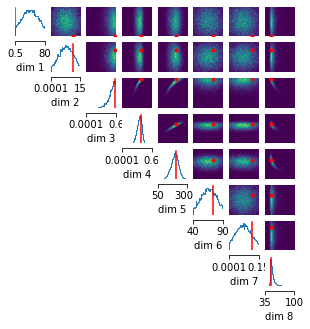

In [103]:
samples = posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

In [104]:
posterior_summ=infer(summ_simulation_wrapper, prior, method='SNPE', 
                  num_simulations=1000, num_workers=7)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 325 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

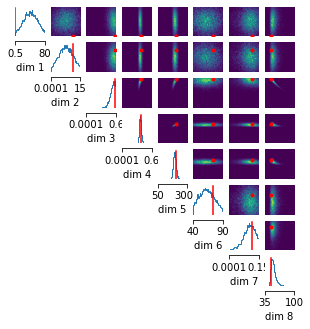

In [105]:
samples = posterior_summ.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(5,5),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

## Load posterior

In [24]:
with open('saved_posteriors/dataset_1/raw_data','rb') as f:
    raw_data = pickle.load(f)
    
hausdorff_simulator_load = get_hausdorff_simulator(raw_data)

In [15]:
with open('saved_posteriors/dataset_1/haus_posterior','rb') as f:
    haus_posterior = pickle.load(f)

In [22]:
with open('saved_posteriors/dataset_1/summ_posterior','rb') as f:
    summ_posterior = pickle.load(f)

In [17]:
with open('saved_posteriors/dataset_1/par_obs','rb') as f:
    par_obs = pickle.load(f)

In [21]:
true_params = par_obs[0][0]
observation = par_obs[1][0]

In [25]:
points_ref = hausdorff_simulator_load(true_params, observation)
summs_ref = calculate_summary_statistics(observation)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

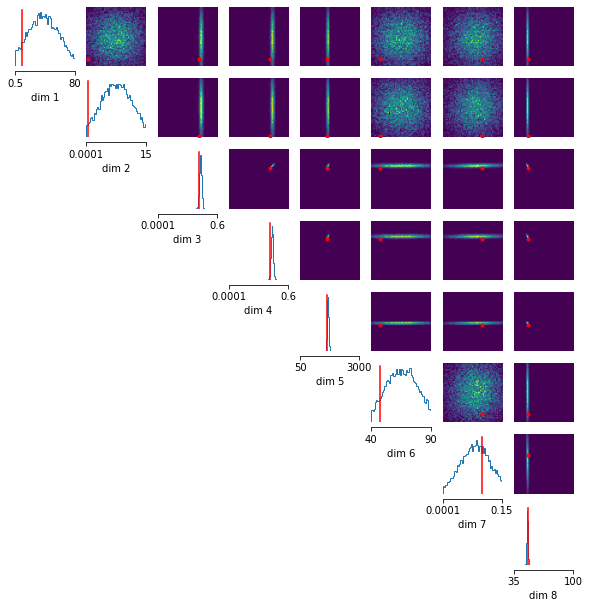

In [29]:
samples = haus_posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

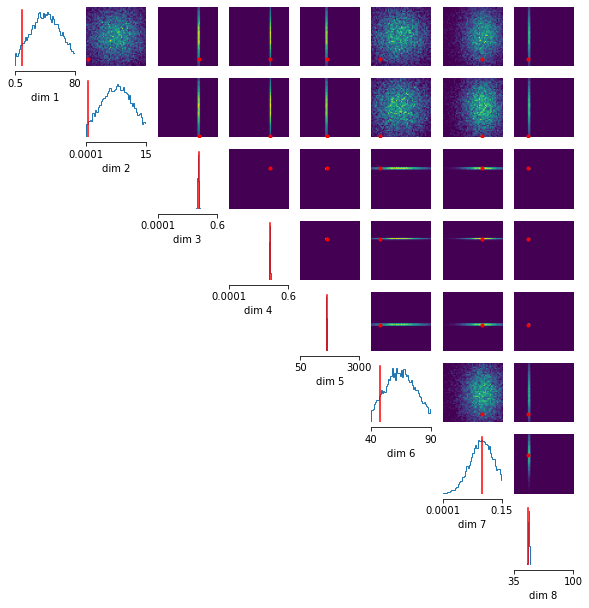

In [30]:
samples = summ_posterior.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

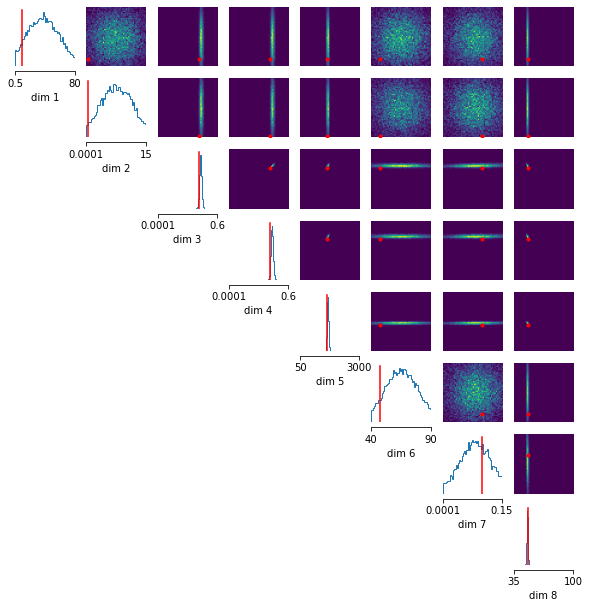

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

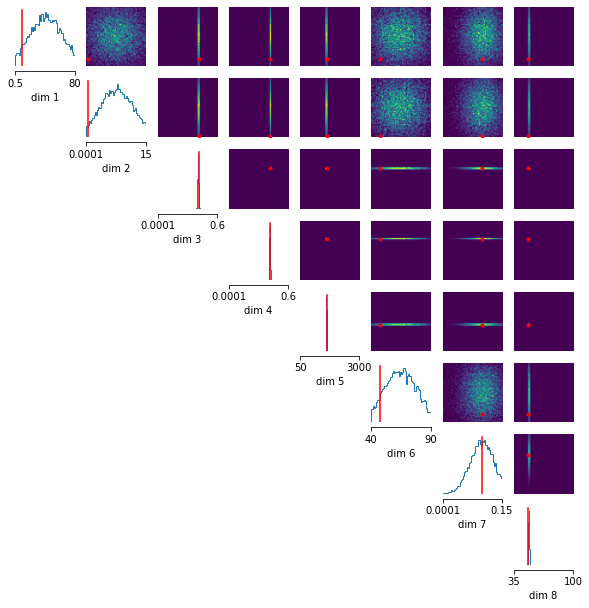

In [31]:
true_params = par_obs[0][1]
observation = par_obs[1][1]
points_ref = hausdorff_simulator_load(true_params, observation)
summs_ref = calculate_summary_statistics(observation)

samples = haus_posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

samples = summ_posterior.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

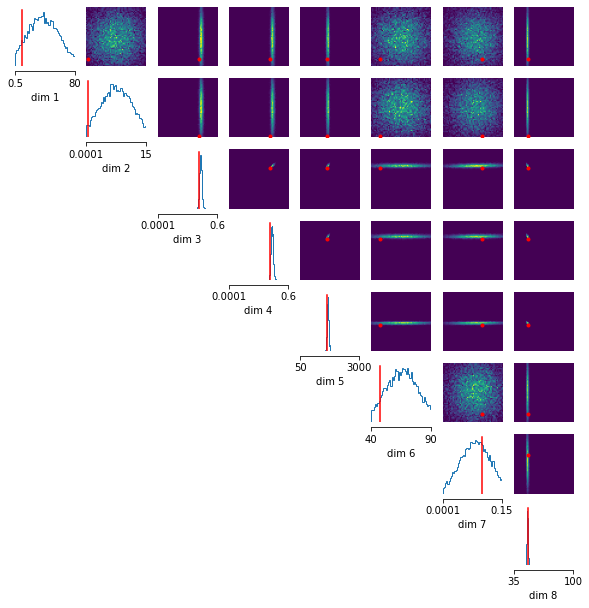

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

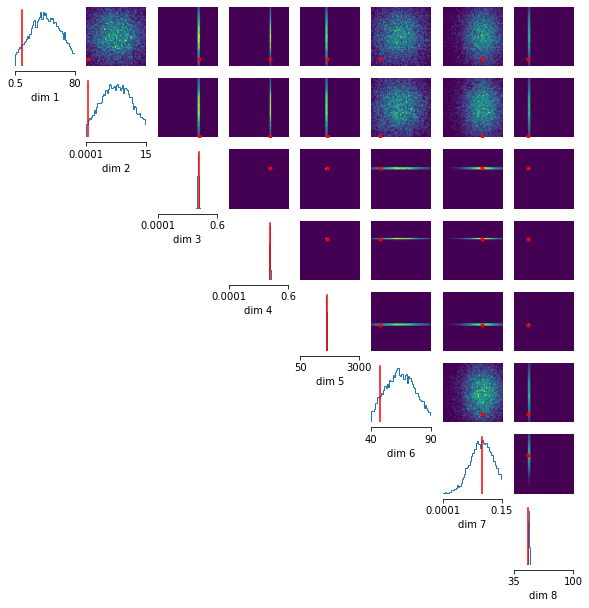

In [32]:
true_params = par_obs[0][1]
observation = par_obs[1][1]
points_ref = hausdorff_simulator_load(true_params, observation)
summs_ref = calculate_summary_statistics(observation)

samples = haus_posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

samples = summ_posterior.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

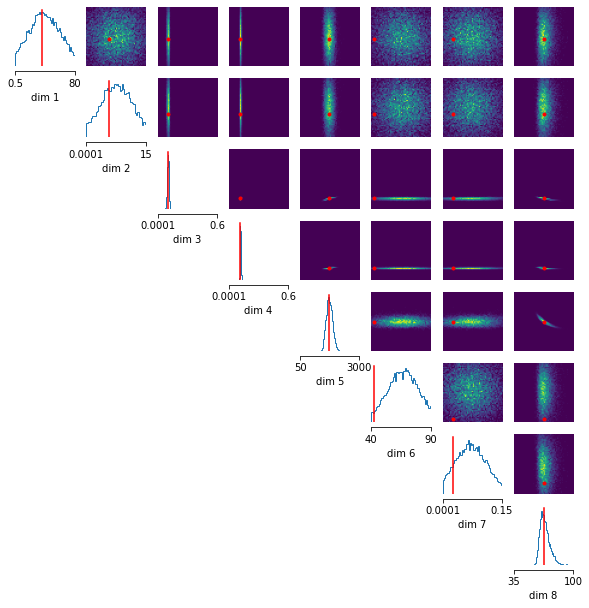

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

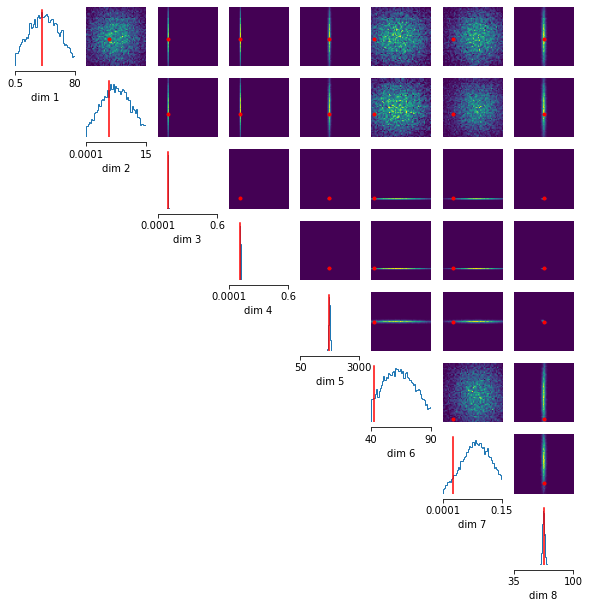

In [33]:
true_params = par_obs[0][2]
observation = par_obs[1][2]
points_ref = hausdorff_simulator_load(true_params, observation)
summs_ref = calculate_summary_statistics(observation)

samples = haus_posterior.sample((10000,),x=points_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()

samples = summ_posterior.sample((10000,),x=summs_ref)
fig, axes = analysis.pairplot(samples,
                        limits=list(zip(prior_min, prior_max)),
                        ticks=list(zip(prior_min, prior_max)),
                        figsize=(10,10),
                        points=true_params,
                        points_offdiag={'markersize': 6},
                        points_colors='r');
plt.show()